In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [60]:
class TS_4_TSP():
    def __init__(self, data, tabuLen, selectNum, threshold, max_epoch):
        self.cityNum = data.shape[0]
        self.threshold = threshold  # 每个初始解未下降次数阈值
        self.dist = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵 
        self.selectNum = selectNum  # 从领域中选择的领域解数目
        self.tabuLen = tabuLen      # 此处禁忌长度=禁忌表大小
        self.max_epoch = max_epoch  # 最大迭代次数
        solutions = list() #多初始点
        for c in range(self.cityNum):
            cities = list(range(self.cityNum))
            cities.remove(c)
            templist = random.sample(cities, self.cityNum-1)
            templist.append(c)
            templist.reverse()
            solutions.append(templist)
        self.solutions = solutions # 初始解-城市的全排列 list类型
        self.values = np.inf * np.ones(self.cityNum)  # 当前状态值
        for i in range(self.cityNum):  #计算当前状态值
            self.values[i] = self.calcuValue(self.solutions[i])
        self.valuesNotDownCount = np.zeros(self.cityNum)
        self.tabus = list()
        for i in range(self.cityNum):
            self.tabus.append(list())
        return
    
    def calcuValue(self, solution):  # 计算目标值-距离
        value = 0
        for c in range(self.cityNum-1):
            value += self.dist[solution[c], solution[c+1]]
        value += self.dist[solution[0], solution[self.cityNum-1]]
        return value
        
    def pick_from_Nx(self, x):  # 从当前状态领域中挑选一个状态
        # input x - 当前解 - 一个城市的全排列
        # return 城市的全排列 list类型
        initcity = x[0]
        flag = True
        while flag:
            exchange_index = sorted(random.sample(range(1,self.cityNum), 2))
            exchange = (x[exchange_index[0]],x[exchange_index[1]])
            if exchange in self.tabus[initcity]:
                continue   
            solution = x.copy()
            solution[exchange_index[0]] = x[exchange_index[1]]
            solution[exchange_index[1]] = x[exchange_index[0]]
            flag = False 
        return solution,exchange
    
    def getNx(self, x):
        initcity = x[0]
        i = 0
        index = 0
        nxSet = list()
        best = np.inf
        exchange = None
        while i < self.selectNum:
            new,change = self.pick_from_Nx(x)
            if new not in nxSet:
                value = self.calcuValue(new)
                if value < best:
                    best = value
                    index = i
                    exchange = change
                nxSet.append(new)
                i += 1
        if best < self.values[initcity]:
            self.solutions[initcity] = nxSet[index][:self.cityNum]
            self.values[initcity] = best
            self.valuesNotDownCount[initcity] = 0
            if len(self.tabus[initcity]) < self.tabuLen:
                self.tabus[initcity].append(exchange)
            else:
                temp = list()
                for i in range(1,self.tabuLen):
                    temp.append(self.tabus[initcity][i])
                temp.append(exchange)
                self.tabus[initcity] = temp    
        else:
            self.valuesNotDownCount[initcity] += 1
        return
    
    def run(self):
        t = 0
        iterate = list()
        while t < self.max_epoch:
            t += 1
            for i, s in enumerate(self.solutions): 
                self.getNx(s)
            for j, c in enumerate(self.valuesNotDownCount):
                if c > self.threshold and len(self.tabus[j])>0:
                    self.tabus[j].pop(-1)
            iterate.append(np.min(self.values))
        return self.values, self.solutions, iterate
            

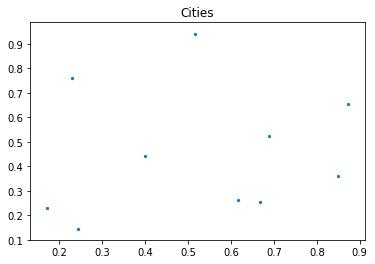

array([[0.        , 0.33605501, 0.31405676, 0.36012623, 0.51109555,
        0.51758316, 0.29818256, 0.45641039, 0.32893613, 0.28211943],
       [0.33605501, 0.        , 0.11066725, 0.61487336, 0.84072721,
        0.80831416, 0.58148308, 0.6418389 , 0.4377541 , 0.38966652],
       [0.31405676, 0.11066725, 0.        , 0.53491948, 0.79188343,
        0.82069284, 0.59414407, 0.69075189, 0.49819298, 0.44642137],
       [0.36012623, 0.61487336, 0.53491948, 0.        , 0.33966601,
        0.6527955 , 0.51709869, 0.73746882, 0.67095138, 0.6310002 ],
       [0.51109555, 0.84072721, 0.79188343, 0.33966601, 0.        ,
        0.4578603 , 0.45290036, 0.66858443, 0.70422317, 0.68624941],
       [0.51758316, 0.80831416, 0.82069284, 0.6527955 , 0.4578603 ,
        0.        , 0.22741603, 0.29371525, 0.44942631, 0.46831504],
       [0.29818256, 0.58148308, 0.59414407, 0.51709869, 0.45290036,
        0.22741603, 0.        , 0.22768838, 0.2690077 , 0.26937292],
       [0.45641039, 0.6418389 , 0.6907518

In [2]:
data = np.array(pd.read_excel("../dataSet/cities3.xlsx",header=None))
plt.title("Cities")
plt.scatter(data[:,0],data[:,1],s=5)
plt.show()
squareform(pdist(data, metric='euclidean'))

In [231]:
tabuLen = 10
selectNum = 11
threshold = 5
max_epoch = 40

In [279]:
ts = TS_4_TSP(data,tabuLen,selectNum,threshold,max_epoch)
values, solutions,iterate = ts.run()
print('初始点','\t巡回距离','\t城市序列')
for i in range(data.shape[0]):
    print(' ',i,'\t',round(values[i],4),'\t',solutions[i])

初始点 	巡回距离 	城市序列
  0 	 3.0344 	 [0, 8, 9, 1, 2, 3, 4, 5, 7, 6]
  1 	 2.6902 	 [1, 2, 0, 3, 4, 5, 6, 7, 8, 9]
  2 	 3.1556 	 [2, 6, 7, 5, 4, 3, 0, 8, 9, 1]
  3 	 2.6902 	 [3, 4, 5, 6, 7, 8, 9, 1, 2, 0]
  4 	 2.6902 	 [4, 3, 0, 2, 1, 9, 8, 7, 6, 5]
  5 	 2.7513 	 [5, 6, 4, 3, 0, 2, 1, 9, 8, 7]
  6 	 3.4091 	 [6, 8, 9, 3, 4, 5, 7, 1, 2, 0]
  7 	 2.6902 	 [7, 6, 5, 4, 3, 0, 2, 1, 9, 8]
  8 	 2.9035 	 [8, 7, 5, 4, 3, 2, 1, 0, 6, 9]
  9 	 3.1569 	 [9, 0, 3, 4, 5, 7, 6, 2, 1, 8]


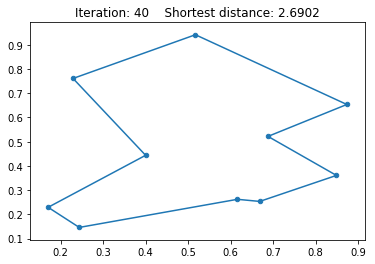

In [179]:
bestIndex = np.argmin(values)
value = round(values[bestIndex],4)
solution = solutions[bestIndex]
solution.append(solution[0])
plt.title("Iteration: "+str(max_epoch)+"    Shortest distance: "+ str(value))
plt.scatter(data[:,0],data[:,1],s=20)
plt.plot(data[solution,0],data[solution,1])
fileName = "%s%s%s" %("最短路径",str(value),".png")
plt.savefig(fileName)
plt.show()

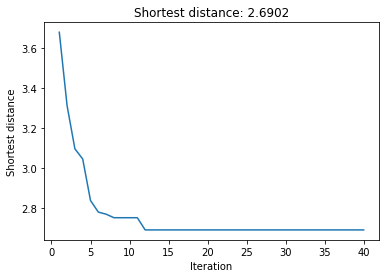

In [280]:
plt.title("Shortest distance: "+ str(value))
plt.plot(list(range(1,max_epoch+1)),iterate)
plt.xlabel('Iteration')
plt.ylabel('Shortest distance')
fileName = "%s%s" %("收敛过程",".png")
plt.savefig(fileName)
plt.show()